# ПРОЕКТ "ОПТИМИЗАЦИЯ МАРКЕТИНГОВЫХ ЗАТРАТ ЯНДЕКС.АФИША"


В данном проекте на основе данных сервиса "Яндекс.Афиша" мы изучим поведение пользователей, рассчитаем все необходимые метрики, сделаем их визуализации.
По результатам исследдования сформулируем рекомендации маркетологам сервиса касательно распределения бюджетных средств на маркетинг.


# Содержание

[1. Загрузка данных](#1)

[2. Расчет ключевых метрик](#2)
    
   [2.1. ПРОДУКТ](#2.1)
   
   [2.1.1 DAU, MAU, WAU](#2.1)
        
   [2.1.2 Количество сессий в день](#2.1.2)
        
   [2.1.3 Длительности сессии](#2.1.3)
        
   [2.1.4 Retention Rate](#2.1.4)
        
   [2.2 ПРОДАЖИ](#2.2)
    
   [2.2.1 Начало продаж](#2.2)
        
   [2.2.2 Количество заказов за период](#2.2.2)
        
   [2.2.3 Средний чек](#2.2.3)
        
   [2.2.4 LTV](#2.2.4)
        
   [2.3 МАРКЕТИНГ](#2.3)
    
   [2.3.1 CAC](#2.3) 
        
   [2.3.2 Расходы по месяцам на каждый источник](#2.3.2)
        
   [2.3.4 LTV по источникам и месяцам](#2.3.4)
        
   [2.3.5 ROMI](#2.3.5)
        
[3. Вывод по проекту](#3)



# 1. Загрузка и подготовка данных
<a id ="1"> </a>

Первым делом мы загрузим все данные о визитах, заказах и расходах пользователей в переменные. Проверим их на пропуски и наличие артефактов.

In [617]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


## 1.1 
Сохраним данные о **визитах на сайт** в переменной `visits`:

In [618]:
visits = pd.read_csv('/datasets/visits_log.csv')
visits.head(10)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


In [619]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']

In [620]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null object
source_id    359400 non-null int64
start_ts     359400 non-null object
uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [621]:
visits['device'].value_counts()

desktop    262567
touch       96833
Name: device, dtype: int64

In [622]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'])

In [623]:
visits['start_ts'] = pd.to_datetime(visits['start_ts'])

In [624]:
visits.isna().sum()

device       0
end_ts       0
source_id    0
start_ts     0
uid          0
dtype: int64

In [625]:
visits.duplicated().sum()

0

### Вывод:
В таблице приведены данные о типе устройства (мобильное или компьютер), дате и времени начала и конца сессии, а так же уникальные номера пользователя и рекламного источника, из которого он перешел на сайт.
Мы привели названия столбцов к нижнему регистру без пробелов и изменили тип данных в столбцах с датами.

Пропусков и дубликатов в таблице не обнаружено.

## 1.2
Выгрузим данные о **заказах** и сохраним их в переменной `orders`:

In [626]:
orders = pd.read_csv('/datasets/orders_log.csv')
orders.head(10)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


In [627]:
orders.columns=['buy_ts', 'revenue', 'uid']

In [628]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null object
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [629]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

In [630]:
orders.isna().sum()

buy_ts     0
revenue    0
uid        0
dtype: int64

In [631]:
orders.duplicated().sum()

0

### Вывод:
В таблице отражены уникальные номера пользователей, а так же время заказа и объем полученной выручки.
Названия столбцов приведены к общепринятому виду, тип данных в столбце с датой изменен.
Пропусков и дубликатов в таблице не обнаружено.

## 1.3
Теперь загрузим информацию о **маркетинговых затратах** компании в переменную `costs`:

In [632]:
costs = pd.read_csv('/datasets/costs.csv')
costs.head(10)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


In [633]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [634]:
costs['dt'] = pd.to_datetime(costs['dt'])

In [635]:
costs.isna().sum()

source_id    0
dt           0
costs        0
dtype: int64

In [636]:
costs.duplicated().sum()

0

In [637]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


### Вывод:
В последней таблице представлены затраты на различные рекламные источники с указанием даты и суммы затрат.
Тип данных столбца с датой исправлен, вносить изменения в названия столбцов не потребовалось.

Пропусков и дубликатов в таблице не обнаружено.

<a id="2"></a>

# 2. Расчет ключевых метрик

## 2.1. ПРОДУКТ


<a id ="2.1.1"> </a>
### 2.1.1 DAU, MAU, WAU
Сначала рассчитаем **количество пользователей сервиса в день, неделю и месяц**.

Для начала выделим необходимые периоды и даты начала сессии клиента.

In [638]:
visits['date'] = visits['start_ts'].dt.date

In [639]:
visits['week'] = visits['start_ts'].dt.week

In [640]:
visits['month'] = visits['start_ts'].dt.month

In [641]:
visits['year'] = visits['start_ts'].dt.year

In [642]:
visits.head()

,device,end_ts,source_id,start_ts,uid,date,week,month,year
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,2017
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2,2018
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,7,2017
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,52,12,2017


In [643]:
dau_total = visits.groupby(['date']).agg({'uid':'nunique'})
dau = dau_total.mean()
print("Ежедневная аудитория сайта {0:.0f} человек".format(dau[0]))


Ежедневная аудитория сайта 908 человек


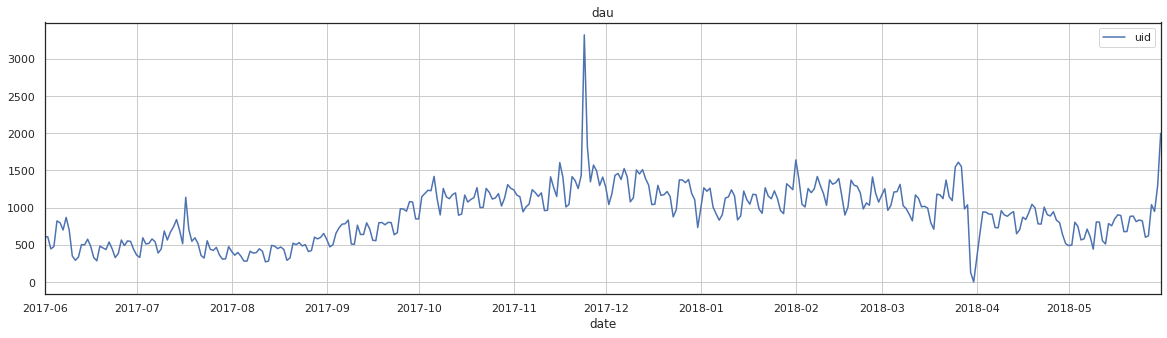

In [644]:
dau_total.plot(title = 'dau', figsize=(20,5),grid=True)
plt.show()


In [645]:
wau_total = visits.groupby(['year', 'week']).agg({'uid':'nunique'})
wau = wau_total.mean()
print("Еженедельная аудитория сайта {0:.0f} человек".format(wau[0]))


Еженедельная аудитория сайта 5716 человек


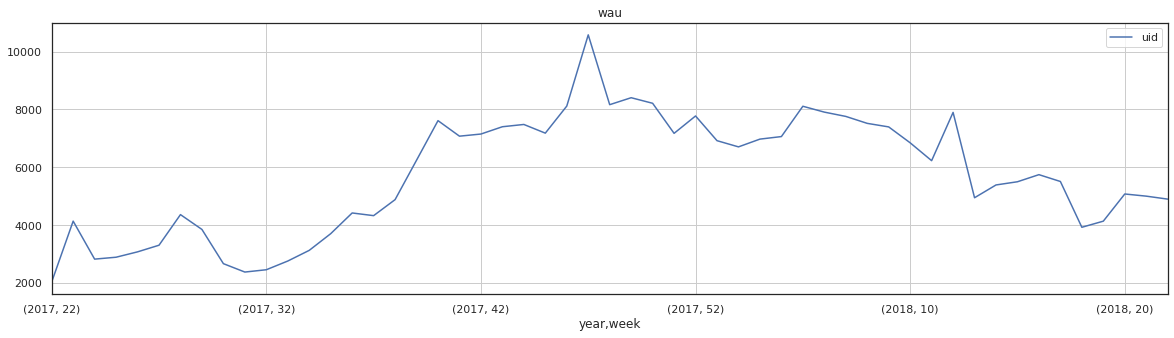

In [646]:
wau_total.plot(title = 'wau', figsize=(20,5),grid=True)
plt.show()

In [647]:
mau_total = visits.groupby(['year', 'month']).agg({'uid':'nunique'})
mau = mau_total.mean()
print("Ежемесячная аудитория сайта {0:.0f} человек".format(mau[0]))

Ежемесячная аудитория сайта 23228 человек


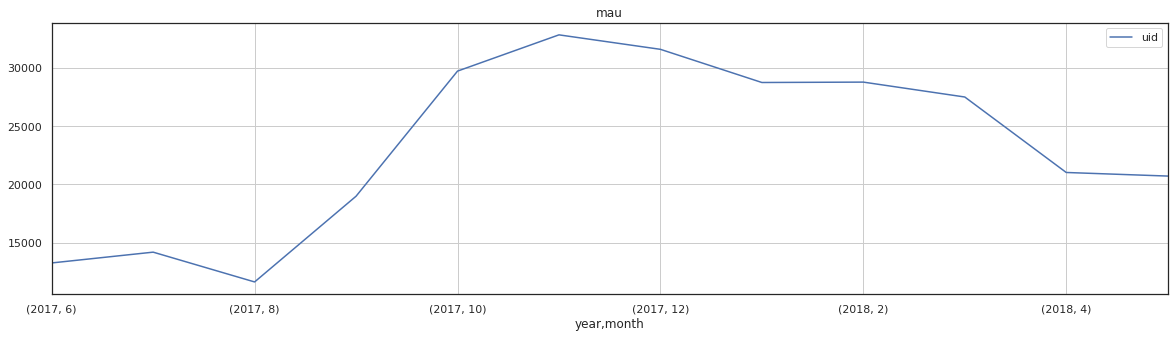

In [648]:
mau_total.plot(title = 'mau', figsize=(20,5),grid=True)
plt.show()

## Вывод:
Итого ежедневно на сайт в среднем заходит **907** уникальных пользователей, в неделю их в среднем **5716**, а в месяц - **23.228 человек**.


На графиках наглядно отражено, что активнее всего сайт посещается в зимний период, самым явным пиком являются предновогодние недели и в целом до марта пользователи очень активно интересуются мероприятиями. Это объясняется тем фактом, что на данный период приходится большинство премьер в кино, театрах и выставочных залах. 
Лето - период затишья в киноиндустрии, театры уезжают на летние гастроли, а большинство людей предпочитают проводить время на свежем воздухе и в отпусках. Этой же закономернос объясняется и провал посещаемости накануне майских праздников.


<a id ="2.1.2"> </a>

### 2.1.2 
Рассчитаем **количество сессий в день**:

,uid
count,364.000000
mean,987.362637
std,418.994796
min,1.000000
25%,635.500000
50%,1003.000000
75%,1280.000000
max,4042.000000


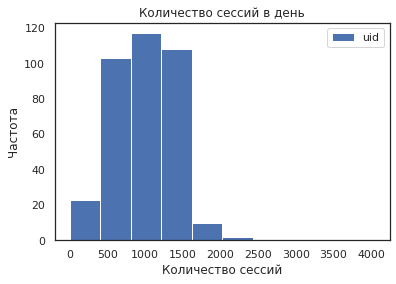

In [649]:
session_per_day = visits.groupby('date').agg({'uid':'count'})

ax = session_per_day.plot(kind='hist', title='Количество сессий в день')
ax.set_xlabel('Количество сессий')
ax.set_ylabel('Частота')
session_per_day.describe()

count    228169.000000
mean          1.575148
std           4.646800
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         893.000000
Name: start_ts, dtype: float64

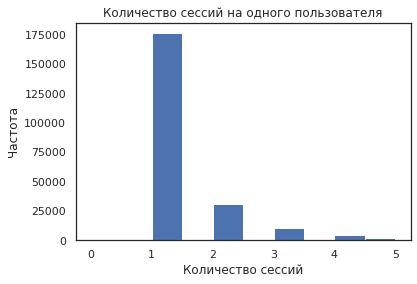

In [650]:
session_per_user = visits.groupby('uid')['start_ts'].count()
ax = session_per_user.plot(kind='hist', title='Количество сессий на одного пользователя', range=(0,5))
ax.set_xlabel('Количество сессий')
ax.set_ylabel('Частота')
session_per_user.describe()

## Вывод:
На графике видно, что количество сессий в день распределено нормально, за исключением выброса в виде аномально максимального числа сессий (более 4000 за день)  в конце ноября. Это подтверждается нашими графиками в разделе 2.1.1. и может быть связано с повышенным интересом к концертам, спектаклям и кинопремьерам в предпраздничные даты и новогодние каникулы. 

В пользу нормального распределения говорит и тот факт, что медиана и среднее арифметичское практически равны - в среднем на сайте в день совершается около 1000 сессий. И в большинстве случаев (75%) их число не превышает 1280 в день.

Подавляющее большинство пользователей заходят на сайт не чаще 1 раза в день.

<a id ="2.1.3"> </a>
## 2.1.3
Посмотрим, **сколько в среднем длится сессия:**

In [651]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds 
session_mean = visits['session_duration_sec'].mean()
print("Средняя (арифметическая) длительность сессии {0:.0f} секунды".format(session_mean))

Средняя (арифметическая) длительность сессии 644 секунды


Получается, что средняя сессия на сайте длится немногим дольше 10 минут. Посмотрим распределение данной величины на графике:

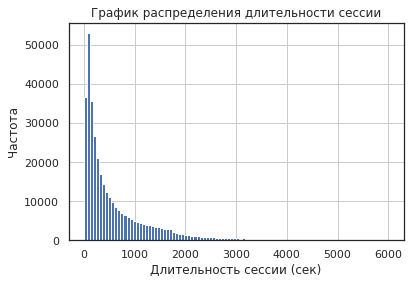

In [652]:
ax = visits['session_duration_sec'].hist(bins=100,range=(0,6000))
plt.title('График распределения длительности сессии')
ax.set_xlabel('Длительность сессии (сек)')
ax.set_ylabel('Частота')
plt.show()

Распределение величины не является нормальным, поэтому ориентироваться на показатель среднего арифмтического будет не корректно.

Обратимся к другим показателям среднего - моде и медиане:

In [653]:
asl = visits['session_duration_sec'].mode()
print("Средняя (модальная) длительность сессии {0:.0f} секунд".format(asl[0]))

Средняя (модальная) длительность сессии 60 секунд


In [654]:
visits['session_duration_sec'].describe()

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_duration_sec, dtype: float64

In [655]:
visits.query('session_duration_sec ==0').count()/len(visits)

device                  0.099594
end_ts                  0.099594
source_id               0.099594
start_ts                0.099594
uid                     0.099594
date                    0.099594
week                    0.099594
month                   0.099594
year                    0.099594
session_duration_sec    0.099594
dtype: float64

## Вывод:
Среди значений длительности сессии есть явные выбросы длительностью почти в сутки. Так же есть некоторое число сеансов с нулевой продолжительностью.

В целом можно говорить о том, что подавляюще большинство пользователей (75%) проводят на сайте не больше 14 минут за 1 сеанс.
Больше всего пользователей завершают сеанс в течение 1 минуты (судя по значению моды), а средним (медианным) временем нахождения на сайте можно считать 5 минут.


Мы рассчитали процент сессий с нулевой длительностью, и таковых оказалось почти 10% от общего числа.
Это довольно высокий показатель, стоит сообщить об этом разработчикам сайта, т.к. проблема может быть в медленной загрузке сайта или некорректном его отображении с разных устройств.

Второй причиной большого числа нулевых сессий может быть случайно попадание пользователей на сайт из-за некорректной настройки источников рекламы. В результате пользователь сразу закрывает сайт, т.к. не имел намерени на него переходить или результат перехода не соответствует его ожиданиям.

<a id ="2.1.4"> </a>
## 2.1.4 Retention Rate

Проведем когортный анализ по посетителям сайта, рассчитаем и построим таблицу `Lifetime` и рассчитаем метрику `Retention Rate`


Первым шагом рассчитаем дату начала активности пользователя на сайте:

In [656]:
first_activity_date = visits.groupby(['uid'])['start_ts'].min()
first_activity_date.name = 'first_activity_date'
first_activity_date.head()


uid
11863502262781    2018-03-01 17:27:00
49537067089222    2018-02-06 15:55:00
297729379853735   2017-06-07 18:47:00
313578113262317   2017-09-18 22:49:00
325320750514679   2017-09-30 14:29:00
Name: first_activity_date, dtype: datetime64[ns]

Для каждого пользователя мы получили дату его первого посещения сайта.

Теперь добавим эту информацию в нашу основную таблицу `visits`:

In [657]:
visits = visits.join(first_activity_date,on='uid') 
visits.head()

,device,end_ts,source_id,start_ts,uid,date,week,month,year,session_duration_sec,first_activity_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,2017,1080,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2,2018,1680,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,7,2017,0,2017-07-01 01:54:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018,1440,2018-03-09 20:05:00
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,52,12,2017,0,2017-12-27 14:06:00


Теперь извлечем из каждой даты посещения сайта и из даты первого посещения месяцы и добавим соответствующие столбцы в таблицу `visits`:

In [658]:
visits['visit_month'] = visits['start_ts'].astype('datetime64[M]')
visits['first_visit_month'] = visits['first_activity_date'].astype('datetime64[M]')
visits.head()

,device,end_ts,source_id,start_ts,uid,date,week,month,year,session_duration_sec,first_activity_date,visit_month,first_visit_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,2017,1080,2017-12-20 17:20:00,2017-12-01,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2,2018,1680,2018-02-19 16:53:00,2018-02-01,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,7,2017,0,2017-07-01 01:54:00,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018,1440,2018-03-09 20:05:00,2018-05-01,2018-03-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,52,12,2017,0,2017-12-27 14:06:00,2017-12-01,2017-12-01


Далее распределим пользователей по когортам(по месяцам и их визитам на сайт) и рассчитаем **lifetime** пользователя в рамках когорты:


In [659]:
visits['cohort_lifetime'] = visits['visit_month'] - visits['first_visit_month']
visits['cohort_lifetime'] = (visits['cohort_lifetime'] / np.timedelta64(1,'M')).round()
visits['cohort_lifetime'] = visits['cohort_lifetime'].astype(int)

Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на каждый месяц:

In [660]:
cohorts = visits.groupby(['first_visit_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index() 
cohorts.head()

,first_visit_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909


Найдём исходное количество пользователей в когорте. Возьмём их число на "нулевой" месяц:

In [661]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month','uid']]
initial_users_count.head()

,first_visit_month,uid
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977


Переименуем столбец `uid` в `cohort_users` и присоединим данные по нулевому месяцу ко всем данным по когортам `cohorts`:

In [662]:
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})


In [663]:
cohorts = cohorts.merge(initial_users_count,on='first_visit_month')

Наконец, рассчитаем **Retention Rate**.

Разделим количество активных пользователей в каждый месяц на исходное число пользователей в когорте:

In [664]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users'] 

Построим сводную таблицу и создадим **тепловую карту**:

In [665]:
retention_pivot = cohorts.pivot_table(index='first_visit_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
retention_pivot


cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Рассчитаем средние значения retention rate по возрастам когорт:

In [666]:
retention_cohort_mean = retention_pivot.mean() * 100
retention_cohort_mean

cohort_lifetime
0     100.000000
1       6.516660
2       4.633262
3       4.275990
4       4.059457
5       3.944383
6       3.695659
7       3.750912
8       3.546465
9       3.515906
10      3.406250
11      4.495060
dtype: float64

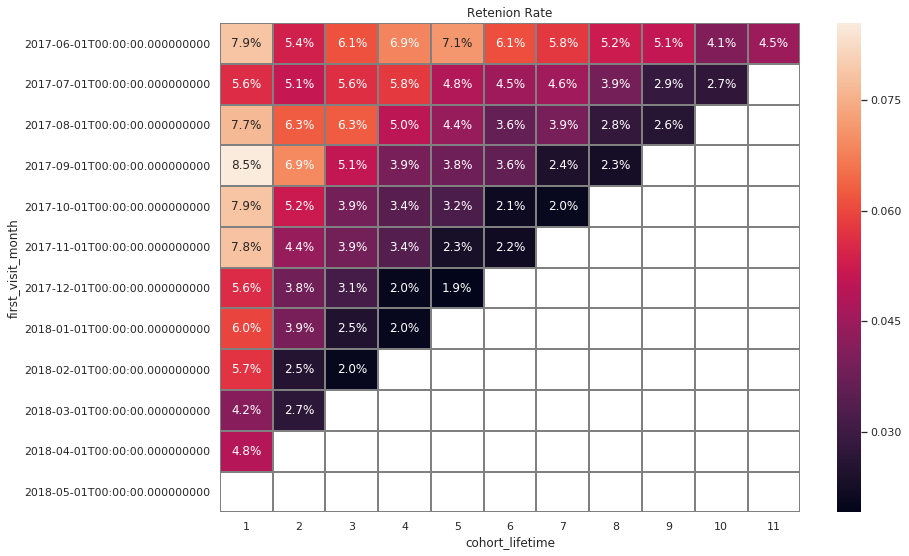

In [667]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Retenion Rate')
sns.heatmap(retention_pivot.iloc[:,1:], annot=True, fmt='.1%', linewidths=1, linecolor='gray'); 

## Вывод:

В целом Retention Rate очень низкий, больше 90-95% пользователей не возвращаются в следующих месяцах.

Конечно, индустрия развлечений подвержена сезонным колебаниям: премьеры выходят неравномерно, пользователи проявляют больший интерес в осенне-зимний период. 


Лучшие показатели у пользователей первой когорты, даже при падении RR почти вдвое, их конечный уровень в два раза выше остальных когорт.

Можно отметить, что в когортах, начиная с ноября 2017 года % возвращающихся пользователей уже на второй месяц стал падать почти вдвое. 

Возможно, реклама стала работать не столь эффективно и стоит оптимизировать маркетинговые затраты на источники трафика. Так же  сайте могли быть внесены изменения,спровоцировавшие отток посетителей.

<a id ="2.2"> </a>

# 2.2 ПРОДАЖИ

## 2.2.1 Начало продаж

Посмотрим, сколько времени проходит между первым визитом пользователя на сайт и первым заказом.


Рассчитаем время первого заказа:

In [668]:
first_order_date = orders.groupby('uid')['buy_ts'].min()
first_order_date.name = 'first_order_date'
first_order_date.head()

uid
313578113262317    2018-01-03 21:51:00
1575281904278712   2017-06-03 10:13:00
2429014661409475   2017-10-11 18:33:00
2464366381792757   2018-01-28 15:54:00
2551852515556206   2017-11-24 10:14:00
Name: first_order_date, dtype: datetime64[ns]

In [669]:
visits = visits.merge(first_order_date, on='uid')
visits.head()

,device,end_ts,source_id,start_ts,uid,date,week,month,year,session_duration_sec,first_activity_date,visit_month,first_visit_month,cohort_lifetime,first_order_date
0,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018,1440,2018-03-09 20:05:00,2018-05-01,2018-03-01,2,2018-03-09 20:25:00
1,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,10,3,2018,1680,2018-03-09 20:05:00,2018-03-01,2018-03-01,0,2018-03-09 20:25:00
2,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-03,35,9,2017,60,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-09-04 12:46:00
3,desktop,2017-10-27 16:02:00,3,2017-10-27 15:20:00,16007536194108375387,2017-10-27,43,10,2017,2520,2017-09-03 21:35:00,2017-10-01,2017-09-01,1,2017-09-04 12:46:00
4,desktop,2017-09-04 17:56:00,4,2017-09-04 17:37:00,16007536194108375387,2017-09-04,36,9,2017,1140,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-09-04 12:46:00


Мы добавили полченные даты в основную таблицу `visits`
Теперь из даты первого посещения и даты первого заказа извлечем день и найдем разницу:

In [670]:
visits['first_visit_day'] = visits['first_activity_date'].dt.date
visits['first_order_day'] = visits['first_order_date'].dt.date

In [671]:
visits['start_buy'] = visits['first_order_day'] - visits['first_visit_day']
visits['start_buy'] = (visits['start_buy'] / np.timedelta64(1, 'D')).round()
visits['start_buy'] = visits['start_buy'].astype('int')

In [672]:
visits['start_buy'].describe()

count    97394.000000
mean        33.713750
std         63.348208
min          0.000000
25%          0.000000
50%          1.000000
75%         37.000000
max        363.000000
Name: start_buy, dtype: float64

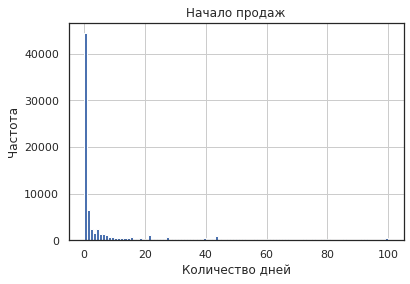

In [673]:
ax = visits['start_buy'].hist(bins=100, range=(0,100))
ax.set_title('Начало продаж')
ax.set_xlabel('Количество дней')
ax.set_ylabel('Частота')
plt.show()

In [674]:
visits_mode = visits['start_buy'].mode()
print("В среднем до начала продаж проходит {0:.0f} дней".format(visits_mode[0]))

В среднем до начала продаж проходит 0 дней


## Вывод:

Не менее четверти пользователей осуществляют первый заказ на сайте в день первого посещения. Больше половины пользователей делают это максимум на следующий день.  У большинства посетителей сайта между первым визитом и первым заказом проходит чуть больше месяца. Хотя есть и выбросы - почти годовой интервал между интересующими нас событиями.

Из-за наличия подобного выброса, среднее арифметическое не может быть достоверным, поэтому согласно медиане и моде мы можем считать, что в среднем пользователи сайта осуществляют заказ в прямо в день первой сессии или на следующий день.



<a id ="2.2.2"> </a>
## 2.2.2 Количество заказов за период

Рассчитаем, сколько заказов пользователи совершают в день, неделю и месяц, а так же объемы выручки за указанные периоды.


Для начала извлечем необходимые периоды из даты совершения заказа:

In [675]:
orders['date'] = orders['buy_ts'].dt.date

In [676]:
orders['week'] = orders['buy_ts'].dt.week

In [677]:
orders['month'] = orders['buy_ts'].dt.month

In [678]:
orders['year'] = orders['buy_ts'].dt.year

In [679]:
orders.head()

,buy_ts,revenue,uid,date,week,month,year
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,22,6,2017
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,22,6,2017
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,22,6,2017
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,22,6,2017
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,22,6,2017


Для начала рассчитаем **число заказов в день:**

In [680]:
orders_per_day = orders.groupby('date')['buy_ts'].count()
orders_per_day.head()

date
2017-06-01     96
2017-06-02    111
2017-06-03     67
2017-06-04     66
2017-06-05    161
Name: buy_ts, dtype: int64

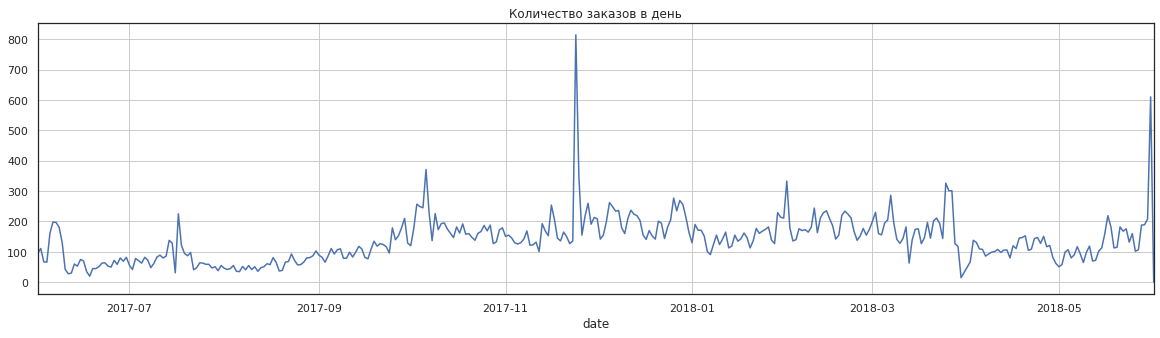

In [681]:
orders_per_day.plot(figsize=(20,5),grid=True,title='Количество заказов в день')
plt.show()

Рассчитаем сразу показатели **ежедневной выручки** и построим график:

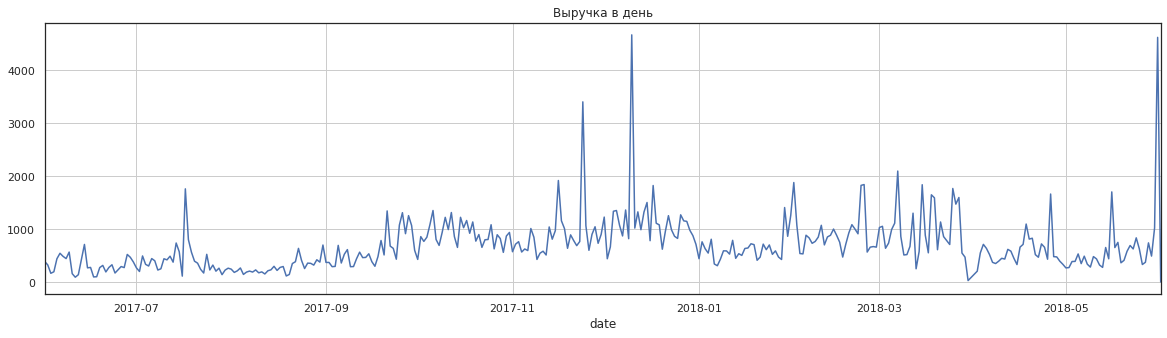

In [682]:
revenue_daily = orders.groupby('date')['revenue'].sum()\
                      .plot(figsize=(20,5),grid=True,title='Выручка в день')                  

Теперь рассмотрим аналогичные **показатели по месяцам**:

In [683]:
orders_per_week = orders.groupby(['year','week'])['buy_ts'].count()


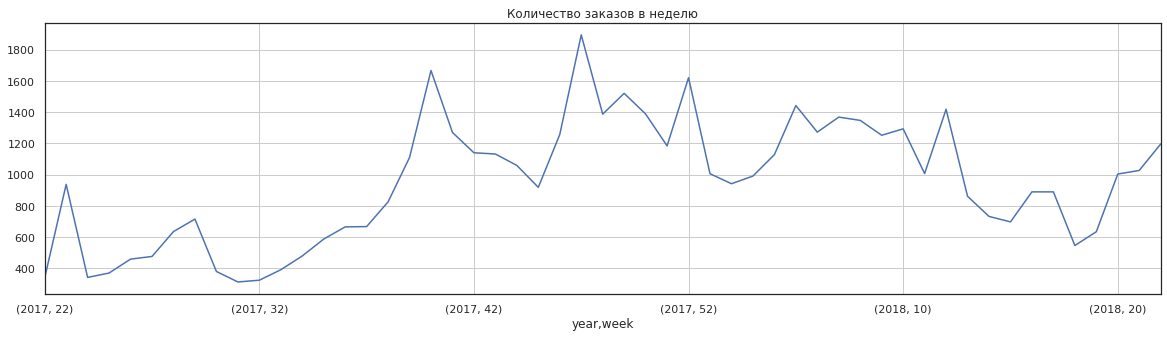

In [684]:
orders_per_week.plot(figsize=(20,5),grid=True, title='Количество заказов в неделю')
plt.show()

Рассчитаем **выручку по месяцам**:

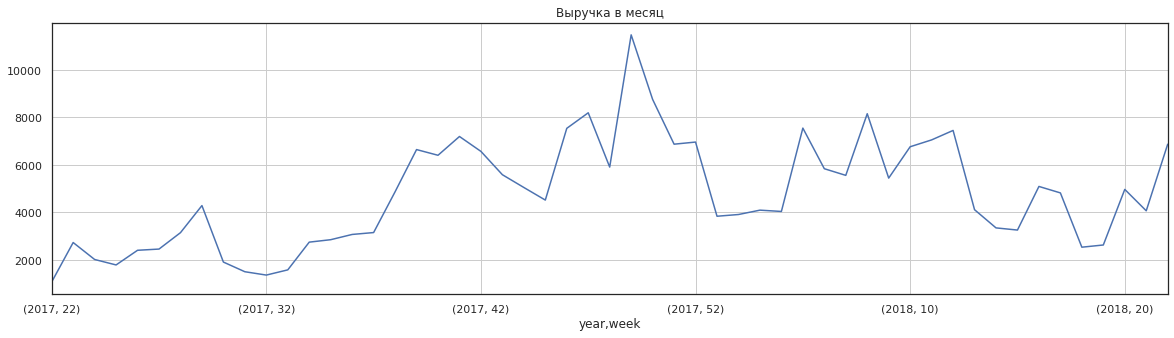

In [685]:
revenue_weekly = orders.groupby(['year','week'])['revenue'].sum()\
                      .plot(figsize=(20,5),grid=True,title='Выручка в месяц')      

In [686]:
orders_per_month = orders.groupby(['year','month'])['buy_ts'].count()
orders_per_month

year  month
2017  6        2354
      7        2363
      8        1807
      9        3387
      10       5679
      11       5659
      12       6218
2018  1        4721
      2        5281
      3        5326
      4        3273
      5        4346
      6           1
Name: buy_ts, dtype: int64

Наконец обобщим расчеты до **месяцев**:

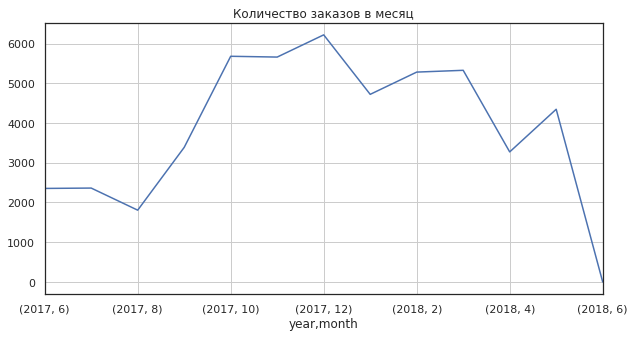

In [687]:
orders_per_month.plot(figsize=(10,5),grid=True, title='Количество заказов в месяц')
plt.show()

График **ежемесячной выручки**:

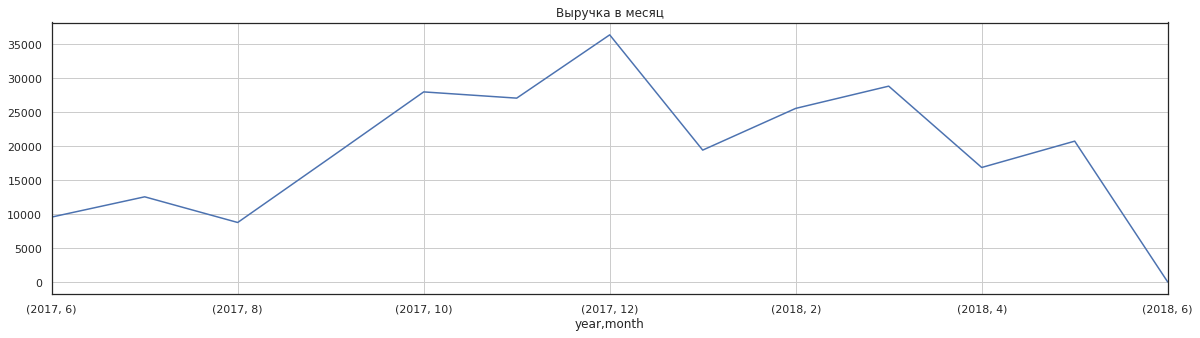

In [688]:
revenue_monthly = orders.groupby(['year','month'])['revenue'].sum()\
                      .plot(figsize=(20,5),grid=True,title='Выручка в месяц')      

## Вывод:

График по количеству заказов в день в целом повторяет график с количеством посещений сайта в день.

В количестве заказов прослеживается аналогичная тенденция посещениям сайта - явно видна сезонность бизнеса с пиковыми продажами накануне зимних каникул и рост спроса в холодное время года, а так же логичное снижение спроса с приближением летних месяцев.

На графике с месяцами наиболее наглядно видна тенденция роста числа заказов в 2018 году по сравнению с аналогичным периодом за предшествующий год. Даже несмотря на сезонный спад весной 2018 число заказов почти вдвое превышает показатели 2017 за аналогичный период.

Показатели выручки прямо пропорциональны числу заказов и имеют идентичные графики за все периоды.

<a id ="2.2.3"> </a>
## 2.2.3 Средний чек

Рассчитаем размер среднего чека, как отношения выручки к количеству заказов и визуализируем его динамику.

In [689]:
orders.head()

,buy_ts,revenue,uid,date,week,month,year
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,22,6,2017
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,22,6,2017
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,22,6,2017
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,22,6,2017
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,22,6,2017


In [690]:
revenue_per_day = orders.groupby('date').agg({'revenue':'mean'}) 


In [691]:
revenue_per_day.describe()

,revenue
count,364.000000
mean,4.936188
std,2.021881
min,1.948000
25%,3.960635
50%,4.561548
75%,5.411037
max,29.133313


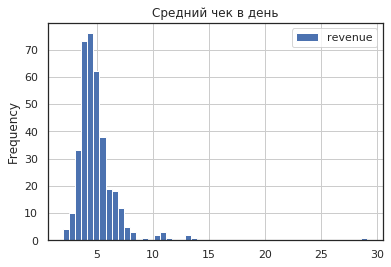

In [692]:
revenue_plot =revenue_per_day.plot(kind='hist', title='Средний чек в день', bins=50, grid=True)

Распределение среднего дневного чека стремится к нормальному, но встречается небольшое число выбросов с суммами в несколько раз превышающими среднее значение. Медиана и среднее арифметическое практически равны и не превышают 5 у.е. Большинство заказов не превышают 6 у.е.

Посмотрим, как этот показатель составляет в масштабах месяца:

In [693]:
revenue_per_month = orders.groupby(['year','month']).agg({'revenue':'mean'}) 
revenue_per_month
                          


revenue
year month          
2017 6      4.060106
     7      5.306589
     8      4.847139
     9      5.416448
     10     4.928280
     11     4.783518
     12     5.852139
2018 1      4.112927
     2      4.840095
     3      5.413930
     4      5.150645
     5      4.771279
     6      3.420000

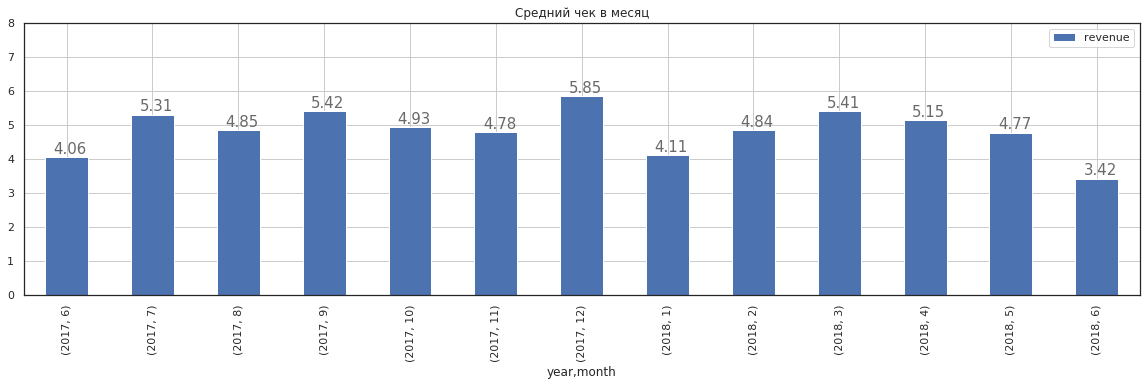

In [694]:
ax = revenue_per_month.plot(kind='bar',title='Средний чек в месяц', 
                                            figsize=(20,5), grid=True)
ax.set_ylim([0,8])

for i in ax.patches:
    ax.text(i.get_x()+.1, i.get_height()+.10, \
            str(round((i.get_height()), 2)), fontsize=15, color='dimgrey')



## Вывод:

Сумма среднего чека в сутки не превышает 5 у.е.
По месяцам средний чек подвержен общему колебанию вместе с количеством заказов и посещений сайта - небольшой спад в январе после новогоднего пика и плавное снижение в летние месяцы. Величина распределена равномерно, отсутствуют явные выбросы в большую или меньшую сторону, величина стандартного отклонения мала. При расчете по месяцам аномальные дневные значения нивелируются, средняя сумма колеблется от 3.4 до 5.8 у.е., в среднем составляет 4.8 у.е. 

<a id ="2.2.4"> </a>
## 2.2.4 LTV 

Для расчета величины LTV применим когортный анализ.

Выделим когорты по месяцам первой покупки из таблицы `orders`.Выделим из даты заказа месяц, приведем его к нужному типу данные и сформируем столбец `order_month`:


In [695]:
orders.head()

,buy_ts,revenue,uid,date,week,month,year
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,22,6,2017
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,22,6,2017
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,22,6,2017
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,22,6,2017
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,22,6,2017


In [696]:
orders['order_month'] = orders['date'].astype('datetime64[M]')
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
first_orders.head()

,uid,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


Посчитаем число новых покупателей в каждом месяце:

In [697]:
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'new_buyers']
cohort_sizes.head()

,first_order_month,new_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


Построим когорты. Добавим месяц первой покупки каждого покупателя в таблицу с заказами:

In [698]:
orders_new = pd.merge(orders,first_orders, on='uid')
orders_new.head()

,buy_ts,revenue,uid,date,week,month,year,order_month,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,22,6,2017,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,22,6,2017,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,22,6,2017,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,22,6,2017,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,22,6,2017,2017-06-01,2017-06-01


Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку:

In [699]:
cohorts_orders = orders_new.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
cohorts_orders.head() 

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


Добавим в таблицу `cohorts_orders` данные о том, сколько людей первый раз совершили покупку в каждый месяц:

In [700]:
report = pd.merge(cohort_sizes, cohorts_orders, on='first_order_month')
report.head()

,first_order_month,new_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


Добавим в таблицу `report` возраст каждой когорты, чтобы затем в сводной таблице получить ответ по месяцам для кадой когорты пользователей:

In [701]:
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report.head()

,first_order_month,new_buyers,order_month,revenue,age
0,2017-06-01,2023,2017-06-01,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,4


Теперь рассчитаем параметр LTV, как соотношение валовой прибыли к количеству заказчиков в месяц.
Поскольку условием нам не задана маржинальность, то принимаем ее равной 100%

In [702]:
report['ltv'] = report['revenue'] / report['new_buyers']
report.head()

,first_order_month,new_buyers,order_month,revenue,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531


In [703]:
output = report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean')
output

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.724414,0.485329,0.437637,0.954671,1.022531,0.735502,0.950440,0.581592,0.553213,0.605788,0.571261,0.256856
2017-07-01,6.010218,0.335211,0.623531,0.358976,0.176791,0.156048,0.120208,0.141820,0.161232,0.147145,0.155673,NaN
2017-08-01,5.276518,0.471993,0.458482,0.391277,0.494051,0.283540,0.210664,0.405007,0.292212,0.187978,NaN,NaN
2017-09-01,5.644529,1.117586,0.520930,3.975792,0.400558,0.647067,0.701608,0.243150,0.184006,NaN,NaN,NaN
2017-10-01,5.003733,0.535763,0.191394,0.157145,0.151560,0.120362,0.084816,0.115470,NaN,NaN,NaN,NaN
2017-11-01,5.154683,0.399233,0.199556,0.324952,0.148013,0.053879,0.114928,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.738191,0.260374,0.925097,1.065275,0.312930,0.338047,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.135636,0.294758,0.304281,0.142778,0.062698,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.156987,0.278274,0.078515,0.074144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Рассчитаем средний LTV по возрастам когорт:

In [704]:
ltv_mean = output.cumsum(axis=1).mean()
ltv_mean

age
0      4.801682
1      5.395666
2      5.821811
3      6.689763
4      7.298634
5      7.969053
6      8.387686
7      9.083583
8     10.062084
9      9.251340
10    10.004616
11    11.879234
dtype: float64

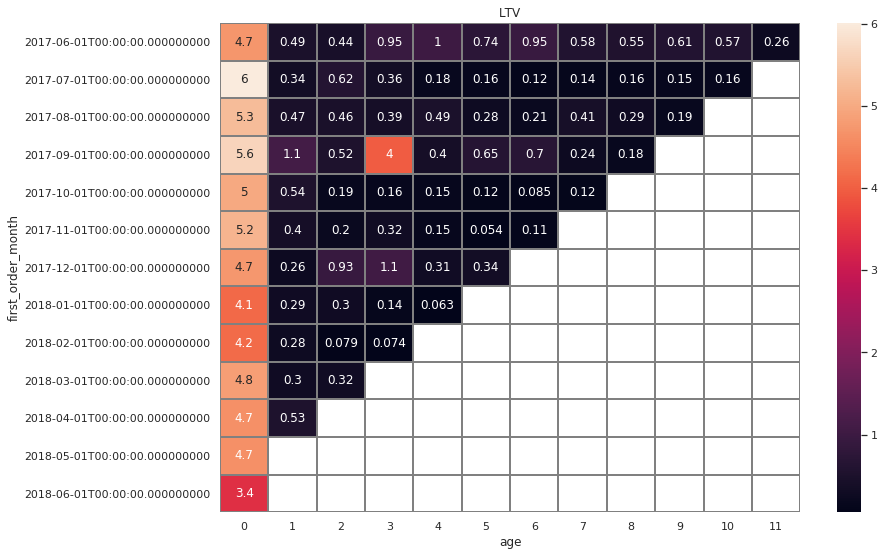

In [705]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('LTV')
sns.heatmap(output, annot=True, linewidths=1, linecolor='gray')
plt.show()

Посчитаем так же накопленный LTV по когортам с течением времени:

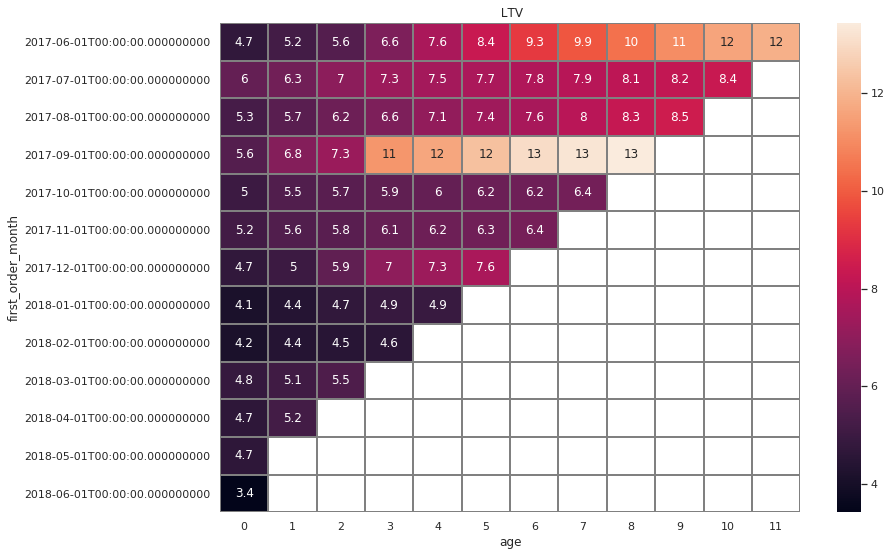

In [706]:
ltv_accum = output.cumsum(axis = 1)
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title(' LTV')
sns.heatmap(ltv_accum, annot=True, linewidths=1, linecolor='gray')
plt.show()

## Вывод:

Таблица и тепловая карта наглядно подтверждают уже доказанные ранее тенденции: низкий Retention Rate ведет к резкому снижению выручки с нового покупателя уже на втором месяце. Отдельные подъемы выручки (например, в сентябрьской когорте) можно объяснить сезонным повышением количества заказов (предновогодний период).

Максимальный LTV показала сентябрьская когорта, имеющая самую высокую прибыль в месяцы пикового спроса.

<a id ="2.3"> </a>
# 2.3 МАРКЕТИНГ

## 2.3.1 CAC (Расходы на привлечение пользователей по месяца и источникам трафика)

Расчет расходов будем производить по таблице `costs`:

In [707]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [708]:
costs['source_id'].value_counts()

5     364
9     363
3     363
1     363
10    363
4     363
2     363
Name: source_id, dtype: int64

Существует 7 источников трафика, условно обозначенных номерами. Расчитаем расход на каждый источник в денежном и процентном соотношении.

Сначала рассчитаем сумму расходов по всем истоникам:

In [709]:
sum_costs = costs['costs'].sum()

print('Сумма расходов по всем источникам: {:.2f} у.е.'.format(sum_costs))


Сумма расходов по всем источникам: 329131.62 у.е.


Теперь найдем сумму по каждому источнику трафика и процентное соотношение расходов к общей сумме маркетинговых затрат.

In [710]:
costs_per_source = costs.groupby('source_id')['costs'].sum().reset_index()
costs_per_source.columns=['source_id', 'costs_per_source']
costs_per_source

,source_id,costs_per_source
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [711]:
costs_per_source['percent'] = ((costs_per_source['costs_per_source'] / sum_costs)*100)
costs_per_source.style.format ({'percent': '{:.2f}%'})


,source_id,costs_per_source,percent
0,1,20833.3,6.33%
1,2,42806,13.01%
2,3,141322,42.94%
3,4,61073.6,18.56%
4,5,51757.1,15.73%
5,9,5517.49,1.68%
6,10,5822.49,1.77%


## Вывод:

Практически половина всех затрат приходится на источник №3, вторая половина распределена на источники №1, 4, 5 и 6.
Источники 9 и 10 почти не финансировались.


Теперь рассчитаем **затраты по месяцам** и отразим их на графике:


In [712]:
costs['month'] = costs['dt'].astype('datetime64[M]')

In [713]:
costs_per_month = costs.groupby(['month']).agg({'costs':'sum'}).reset_index()
costs_per_month.columns = ['month','costs_per_month']
costs_per_month.head()

,month,costs_per_month
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88


In [714]:
costs = pd.merge(costs, costs_per_month, on=('month'))
costs.head()

,source_id,dt,costs,month,costs_per_month
0,1,2017-06-01,75.20,2017-06-01,18015.0
1,1,2017-06-02,62.25,2017-06-01,18015.0
2,1,2017-06-03,36.53,2017-06-01,18015.0
3,1,2017-06-04,55.00,2017-06-01,18015.0
4,1,2017-06-05,57.08,2017-06-01,18015.0


In [715]:
month_lst = ['June', 'July', 'August', 'September', 'October', 'November','December', 'January', 'February', 'March', 'April', 'May']

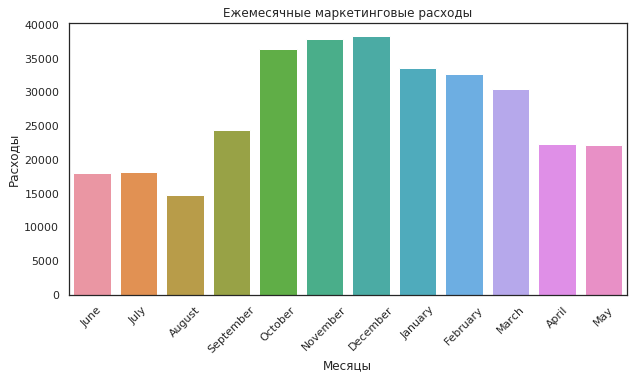

In [716]:
plt.figure(figsize = (10,5))
ax = sns.barplot(x="month", y="costs_per_month", data=costs_per_month)
ax.set_xticklabels(month_lst, rotation=45)
plt.title('Ежемесячные маркетинговые расходы')
ax.set_xlabel('Месяцы')
ax.set_ylabel('Расходы')
plt.show()

## Вывод: 
наибольшие расходы на маркетинг приходятся на октябрь, ноябрь и декабрь 2017 года. В январе и ферале 2018 расходы все еще остаются высокими. Несмотря на это, мы уже определили, что выручка в янрваре по отношению к декабрю снизилась почти двукратно.

Следующим шагом рассчитаем маркетинговые **расходы на каждого привлеченного покупателя в месяц**, затем детализируем их по источникам трафика:


Найдем для каждого пользователя его первый источник трафика:

In [717]:
first_source = visits.sort_values(by='first_visit_month').groupby('uid').agg({'source_id':'first'}).reset_index()
first_source.columns=['uid', 'first_source']
first_source.head()

,uid,first_source
0,313578113262317,2
1,1575281904278712,10
2,2429014661409475,3
3,2464366381792757,5
4,2551852515556206,5


Добавим эту информацию в таблицу `visits`:

In [718]:
visits = pd.merge(visits, first_source, on='uid')
visits.head()

,device,end_ts,source_id,start_ts,uid,date,week,month,year,session_duration_sec,first_activity_date,visit_month,first_visit_month,cohort_lifetime,first_order_date,first_visit_day,first_order_day,start_buy,first_source
0,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018,1440,2018-03-09 20:05:00,2018-05-01,2018-03-01,2,2018-03-09 20:25:00,2018-03-09,2018-03-09,0,4
1,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,10,3,2018,1680,2018-03-09 20:05:00,2018-03-01,2018-03-01,0,2018-03-09 20:25:00,2018-03-09,2018-03-09,0,4
2,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-03,35,9,2017,60,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-09-04 12:46:00,2017-09-03,2017-09-04,1,5
3,desktop,2017-10-27 16:02:00,3,2017-10-27 15:20:00,16007536194108375387,2017-10-27,43,10,2017,2520,2017-09-03 21:35:00,2017-10-01,2017-09-01,1,2017-09-04 12:46:00,2017-09-03,2017-09-04,1,5
4,desktop,2017-09-04 17:56:00,4,2017-09-04 17:37:00,16007536194108375387,2017-09-04,36,9,2017,1140,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-09-04 12:46:00,2017-09-03,2017-09-04,1,5


In [719]:
costs.head()

,source_id,dt,costs,month,costs_per_month
0,1,2017-06-01,75.20,2017-06-01,18015.0
1,1,2017-06-02,62.25,2017-06-01,18015.0
2,1,2017-06-03,36.53,2017-06-01,18015.0
3,1,2017-06-04,55.00,2017-06-01,18015.0
4,1,2017-06-05,57.08,2017-06-01,18015.0


Добавим в нашу отчетную таблицу ежемесячные расходы на маркетинг и рассчитаем столбец **CAC по месяцам:**

In [720]:
report.head()

,first_order_month,new_buyers,order_month,revenue,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531


In [721]:
report_new = pd.merge(report, costs_per_month, left_on='order_month', right_on='month')
report_new['cac'] = report_new['costs_per_month'] / report_new['new_buyers']
report_new.head() 

,first_order_month,new_buyers,order_month,revenue,age,ltv,month,costs_per_month,cac
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,2017-06-01,18015.00,8.905091
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329,2017-07-01,18240.59,9.016604
2,2017-07-01,1923,2017-07-01,11557.65,0,6.010218,2017-07-01,18240.59,9.485486
3,2017-06-01,2023,2017-08-01,885.34,2,0.437637,2017-08-01,14790.54,7.311191
4,2017-07-01,1923,2017-08-01,644.61,1,0.335211,2017-08-01,14790.54,7.691388


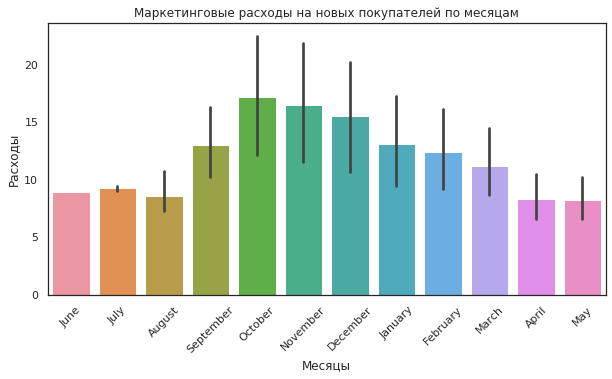

In [722]:
plt.figure(figsize = (10,5))
ax = sns.barplot(x="month", y="cac", data=report_new)
ax.set_xticklabels(month_lst, rotation=45)
plt.title('Маркетинговые расходы на новых покупателей по месяцам')
ax.set_xlabel('Месяцы')
ax.set_ylabel('Расходы')
plt.show()

## Вывод:
В месяцы пониженного спроса расходы на одного привлеченного покупателя возрастают. 

Самая низкая посещаемость и выручка фиксировались в августе 2017, январе и апреле 2018 года - на эти месяцы приходится максимальный размер величины CAC.


Теперь посмотрим, как они распределены по источникам трафика.


<a id ="2.3.2"> </a>
## 2.3.2
Найдем **расходы по месяцам на каждый источник:**

In [723]:
costs_source_month = costs.groupby(['month','source_id'])['costs'].sum().reset_index()
costs_source_month.columns=['month', 'source', 'costs_source']
costs_source_month.tail()

,month,source,costs_source
79,2018-05-01,3,9411.42
80,2018-05-01,4,4214.21
81,2018-05-01,5,3669.56
82,2018-05-01,9,362.17
83,2018-05-01,10,409.86


Теперь рассчитаем **количество новых покупателей из каждого источника по месяцам:**

In [724]:
first_orders.head()

,uid,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


In [725]:
first_orders=pd.merge(first_orders, first_source, on='uid')
first_orders.head()


,uid,first_order_month,first_source
0,313578113262317,2018-01-01,2
1,1575281904278712,2017-06-01,10
2,2429014661409475,2017-10-01,3
3,2464366381792757,2018-01-01,5
4,2551852515556206,2017-11-01,5


In [726]:
new_buyers_source = first_orders.groupby(['first_order_month','first_source']).agg({'uid': 'nunique'}).reset_index()
new_buyers_source.columns = ['first_order_month','source', 'new_buyers_source']
new_buyers_source.head()

,first_order_month,source,new_buyers_source
0,2017-06-01,1,202
1,2017-06-01,2,284
2,2017-06-01,3,569
3,2017-06-01,4,417
4,2017-06-01,5,369


Объединим в одну таблицу данные по расходам на разные источники и количество новых покупателей в месяц из каждого ресурса:

In [727]:
costs_source_month = pd.merge(costs_source_month, new_buyers_source, on=('source'))
costs_source_month.name=['costs_source_month']
costs_source_month.head()



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


,month,source,costs_source,first_order_month,new_buyers_source
0,2017-06-01,1,1125.61,2017-06-01,202
1,2017-06-01,1,1125.61,2017-07-01,187
2,2017-06-01,1,1125.61,2017-08-01,144
3,2017-06-01,1,1125.61,2017-09-01,278
4,2017-06-01,1,1125.61,2017-10-01,434


Теперь мы можем рассчитать **САС по каждому источнику в месяц:**

In [728]:
costs_source_month['cac_source'] = costs_source_month['costs_source'] / costs_source_month['new_buyers_source']
costs_source_month.head()


,month,source,costs_source,first_order_month,new_buyers_source,cac_source
0,2017-06-01,1,1125.61,2017-06-01,202,5.572327
1,2017-06-01,1,1125.61,2017-07-01,187,6.019305
2,2017-06-01,1,1125.61,2017-08-01,144,7.816736
3,2017-06-01,1,1125.61,2017-09-01,278,4.048957
4,2017-06-01,1,1125.61,2017-10-01,434,2.593571


In [730]:
report_source = pd.merge(report, costs_source_month, on='first_order_month')

report_source.head()

,first_order_month,new_buyers,order_month,revenue,age,ltv,month,source,costs_source,new_buyers_source,cac_source
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,2017-06-01,1,1125.61,202,5.572327
1,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,2017-07-01,1,1072.88,202,5.311287
2,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,2017-08-01,1,951.81,202,4.711931
3,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,2017-09-01,1,1502.01,202,7.435693
4,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,2017-10-01,1,2315.75,202,11.464109


<a id ="2.3.4"> </a>
## 2.3.4


Теперь рассчитаем **LTV по источникам и месяцам:**

In [731]:
orders.head()

,buy_ts,revenue,uid,date,week,month,year,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,22,6,2017,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,22,6,2017,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,22,6,2017,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,22,6,2017,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,22,6,2017,2017-06-01


In [732]:
first_orders.head()

,uid,first_order_month,first_source
0,313578113262317,2018-01-01,2
1,1575281904278712,2017-06-01,10
2,2429014661409475,2017-10-01,3
3,2464366381792757,2018-01-01,5
4,2551852515556206,2017-11-01,5


In [733]:
orders['order_month'] = orders['order_month'].astype('datetime64[M]')

Добавим в отчетную таблицу данные о первом месяце заказа и первом источнике трафика для каждого клиента:

In [734]:
revenue_source = pd.merge(orders, first_orders, on='uid')
revenue_source.head()

,buy_ts,revenue,uid,date,week,month,year,order_month,first_order_month,first_source
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,22,6,2017,2017-06-01,2017-06-01,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,22,6,2017,2017-06-01,2017-06-01,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,22,6,2017,2017-06-01,2017-06-01,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,22,6,2017,2017-06-01,2017-06-01,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,22,6,2017,2017-06-01,2017-06-01,3


In [735]:
revenue_source['order_month'] = revenue_source['order_month'].astype('datetime64[M]')

In [736]:
revenue_source['first_order_month'] = revenue_source['first_order_month'].astype('datetime64[M]')

Сформируем размеры когорт по первому месяцу заказа и первому источнику трафика и добавим эту информацию в сводную таблицу:

In [737]:
cohort_sizes_ltv = revenue_source.groupby(by=['first_order_month', 'first_source']).agg({'uid': 'nunique'}).reset_index()
cohort_sizes_ltv.columns = ['first_order_month', 'first_source','new_buyers_source']

cohort_sizes_ltv.head(10) 

,first_order_month,first_source,new_buyers_source
0,2017-06-01,1,202
1,2017-06-01,2,284
2,2017-06-01,3,569
3,2017-06-01,4,417
4,2017-06-01,5,369
5,2017-06-01,9,97
6,2017-06-01,10,85
7,2017-07-01,1,187
8,2017-07-01,2,255
9,2017-07-01,3,458


In [738]:
revenue_total = pd.merge(revenue_source, cohort_sizes_ltv, on=('first_order_month', 'first_source'))
revenue_total.head()

,buy_ts,revenue,uid,date,week,month,year,order_month,first_order_month,first_source,new_buyers_source
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,22,6,2017,2017-06-01,2017-06-01,1,202
1,2017-06-01 09:23:00,0.37,1074355127080856382,2017-06-01,22,6,2017,2017-06-01,2017-06-01,1,202
2,2017-06-01 11:01:00,1.67,6481195116107172636,2017-06-01,22,6,2017,2017-06-01,2017-06-01,1,202
3,2017-06-01 13:29:00,4.58,13788673445849105087,2017-06-01,22,6,2017,2017-06-01,2017-06-01,1,202
4,2017-06-01 14:36:00,0.24,13830803930846284958,2017-06-01,22,6,2017,2017-06-01,2017-06-01,1,202


Рассчитаем прибыль от каждого источника по месяцам `revenue_source_month`:

In [739]:
revenue_source_month = revenue_total.groupby(['first_order_month', 'first_source', 'order_month'])['revenue'].sum().reset_index()
revenue_source_month.columns=['first_order_month', 'source', 'order_month', 'revenue_source_month']
revenue_source_month.head()

,first_order_month,source,order_month,revenue_source_month
0,2017-06-01,1,2017-06-01,1078.99
1,2017-06-01,1,2017-07-01,224.56
2,2017-06-01,1,2017-08-01,74.21
3,2017-06-01,1,2017-09-01,404.90
4,2017-06-01,1,2017-10-01,215.43


Объединим все полученные данные в общую итоговую таблицу и рассчитаем LTV по каждому источнику в месяц:

In [740]:
report_total = pd.merge(report_source, revenue_source_month, on=('first_order_month', 'order_month', 'source'))
report_total.head()

,first_order_month,new_buyers,order_month,revenue,age,ltv,month,source,costs_source,new_buyers_source,cac_source,revenue_source_month
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,2017-06-01,1,1125.61,202,5.572327,1078.99
1,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,2017-07-01,1,1072.88,202,5.311287,1078.99
2,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,2017-08-01,1,951.81,202,4.711931,1078.99
3,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,2017-09-01,1,1502.01,202,7.435693,1078.99
4,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,2017-10-01,1,2315.75,202,11.464109,1078.99


In [741]:
report_total['ltv_source'] = report_total['revenue_source_month'] / report_total['new_buyers_source']
report_total.head()

,first_order_month,new_buyers,order_month,revenue,age,ltv,month,source,costs_source,new_buyers_source,cac_source,revenue_source_month,ltv_source
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,2017-06-01,1,1125.61,202,5.572327,1078.99,5.341535
1,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,2017-07-01,1,1072.88,202,5.311287,1078.99,5.341535
2,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,2017-08-01,1,951.81,202,4.711931,1078.99,5.341535
3,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,2017-09-01,1,1502.01,202,7.435693,1078.99,5.341535
4,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,2017-10-01,1,2315.75,202,11.464109,1078.99,5.341535


<a id="2.3.5"></a>
## 2.3.5

Теперь мы можем рассчитаеть окупаемость **ROMI** каждой когорты по месяцам для каждого источника:

In [742]:
report_total['romi'] = report_total['ltv_source'] / report_total['cac_source']
report_total.head()

,first_order_month,new_buyers,order_month,revenue,age,ltv,month,source,costs_source,new_buyers_source,cac_source,revenue_source_month,ltv_source,romi
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,2017-06-01,1,1125.61,202,5.572327,1078.99,5.341535,0.958582
1,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,2017-07-01,1,1072.88,202,5.311287,1078.99,5.341535,1.005695
2,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,2017-08-01,1,951.81,202,4.711931,1078.99,5.341535,1.133619
3,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,2017-09-01,1,1502.01,202,7.435693,1078.99,5.341535,0.718364
4,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,2017-10-01,1,2315.75,202,11.464109,1078.99,5.341535,0.465935


**ROMI по месяцам без учета источника трафика:**

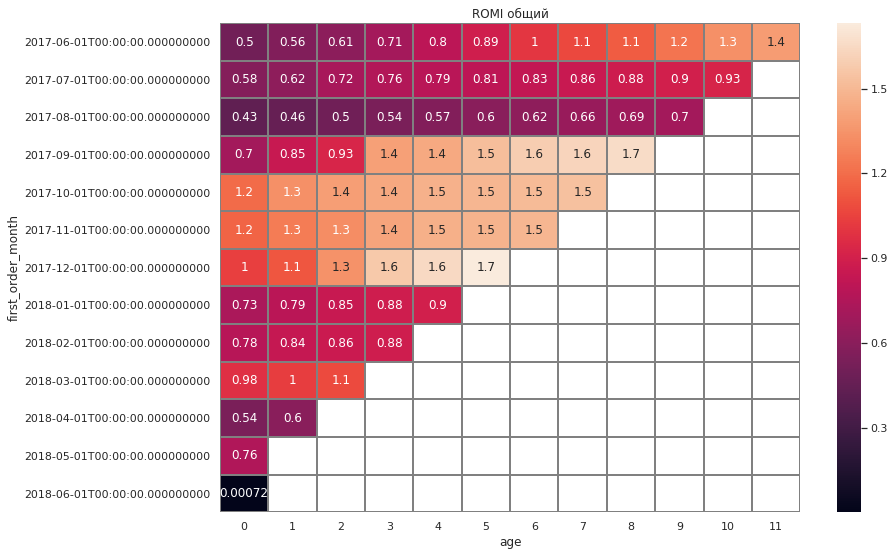

In [743]:
romi_total = report_total.pivot_table(index= 'first_order_month', 
                                      columns='age', values='romi', 
                                      aggfunc='mean').cumsum(axis=1)

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('ROMI общий')
sns.heatmap(romi_total, annot=True, linewidths=1, linecolor='gray') 
plt.show()
    



## Вывод: 

Лучшие показатели окупаемости демонстрируют сентябрьская и декабрьская когорты.
За 2018 год окупилась только мартовская когорта. 
Все логично - пропущенные месяцы летнего спада + месяцы повышенного предновогоднего спроса, включенные в lifetime, гарантируют окупаемость когорты.
Худшие показатели у тех, кто прошел весь летний спад или пропустил предновогодний пик заказов.

Выведем сводные таблицы показателя окупаемости ROMI для каждого источника в отдельности:

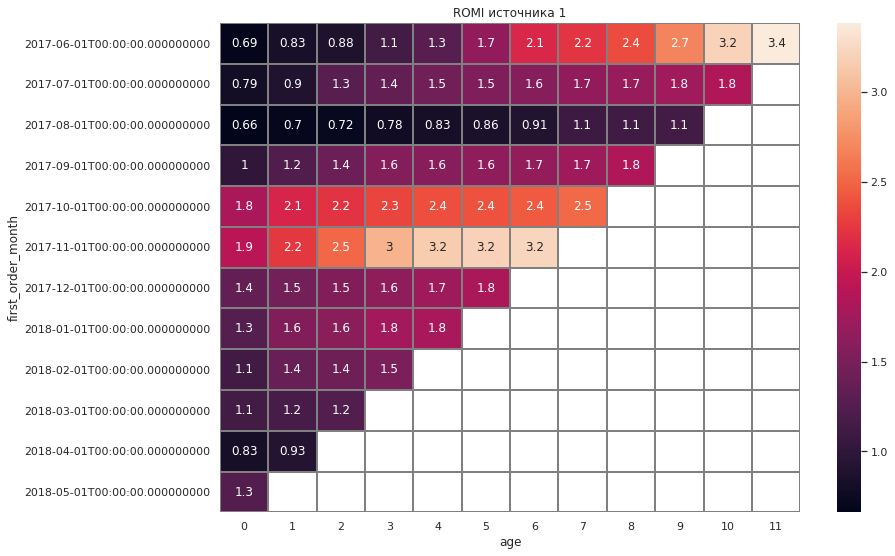

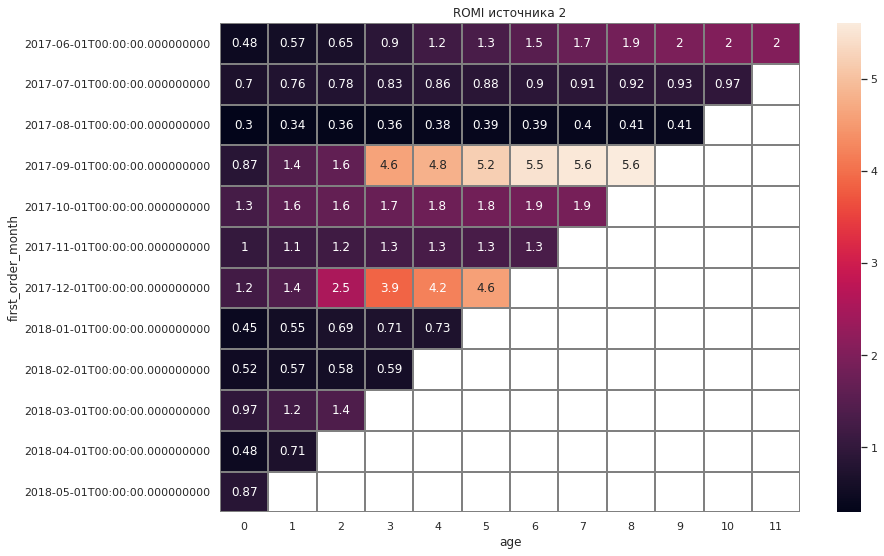

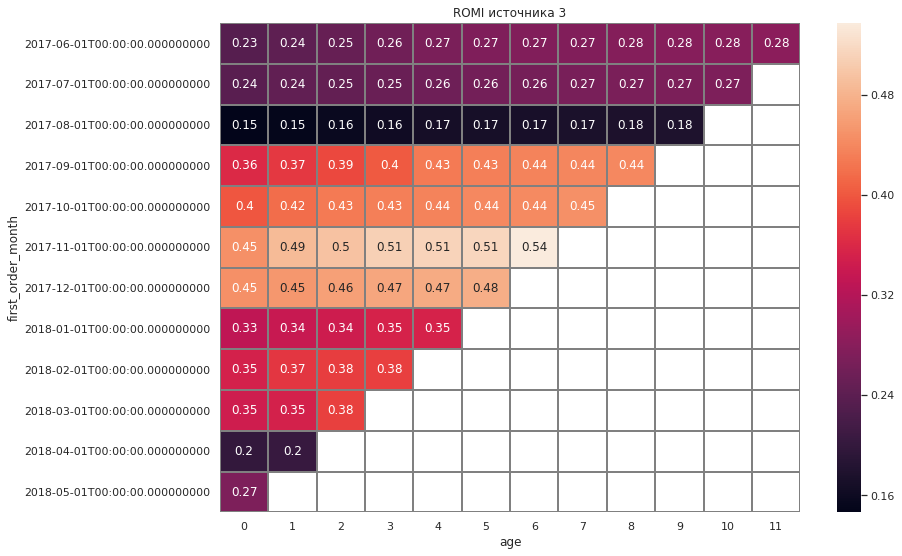

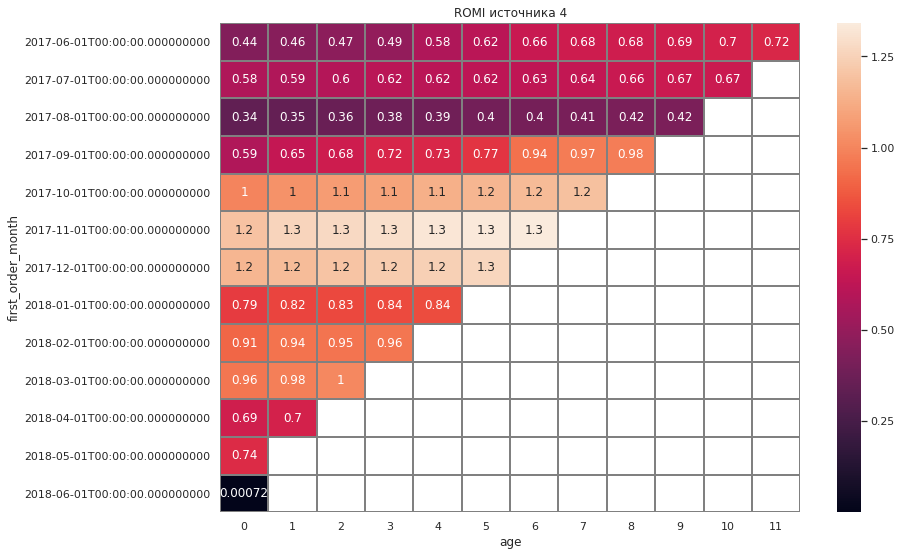

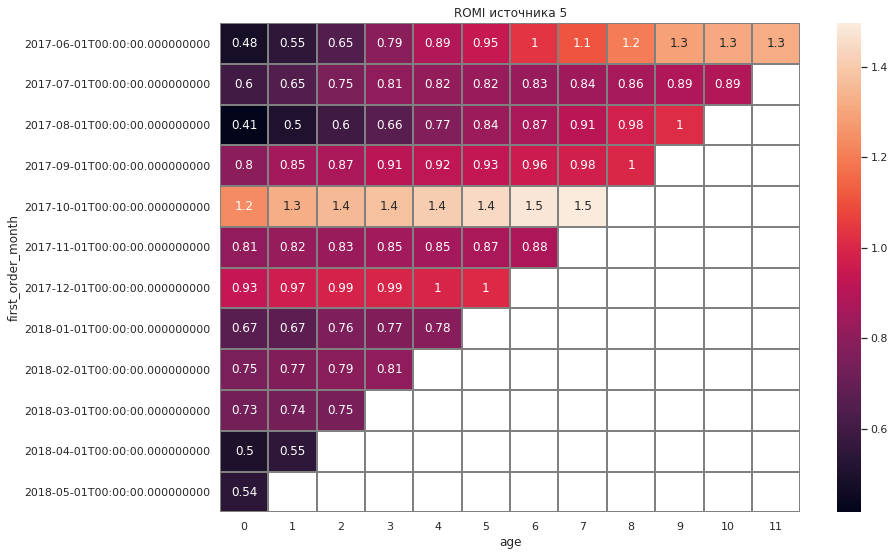

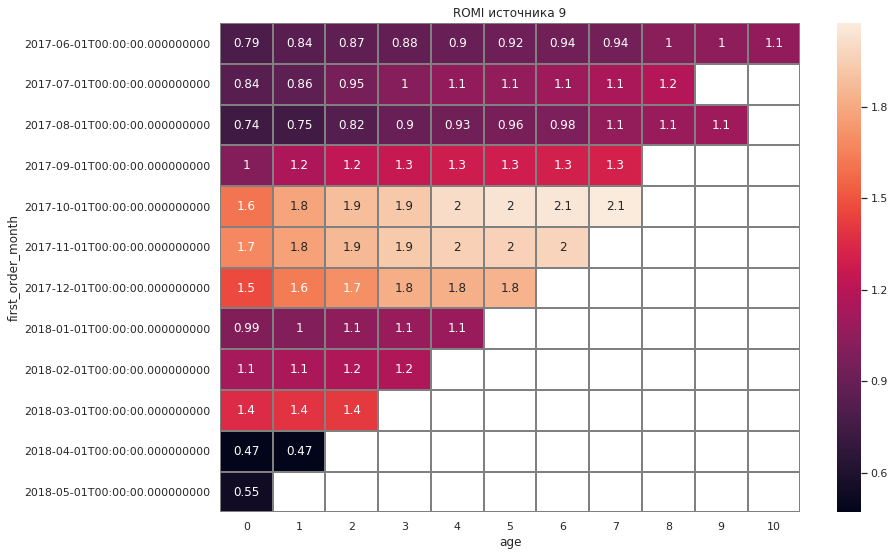

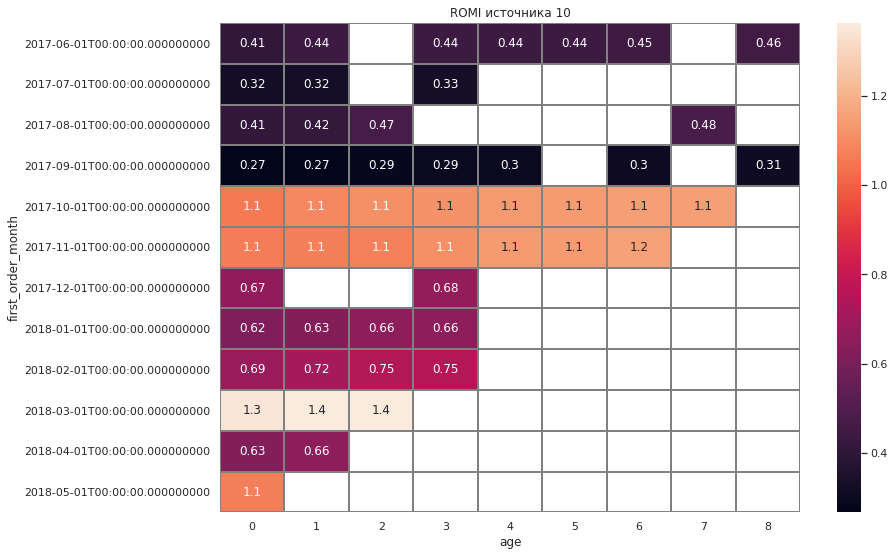

In [744]:
for source in report_total.source.unique():
    out_put = report_total.query('source == @source').pivot_table(index= 'first_order_month', 
                                                        columns='age', values='romi', 
                                                        aggfunc='mean').cumsum(axis=1)
    sns.set(style='white')
    plt.figure(figsize=(13, 9))
    plt.title('ROMI источника {}'.format(source))
    sns.heatmap(out_put, annot=True, linewidths=1, linecolor='gray') 
    plt.show()
    
    

## Вывод:

По **первому источнику** расходы на каждую когорту покупателей окупаются уже на первый-второй месяц.

**Второй источник** дает не такие однородные результаты - по некоторым когортам расходы так и не покрыты, зато другие когорты окупаются в несколько раз за период наблюдения.

**Третий источник** наименее эффективен - за время наблюдений ни одна когорта так и не окупилась, расходы отбились максимум на 30-35%

**Четвертый источник** привел к окупаемости единственной когорты. Процент окупаемости в целом выше, чем по третьему источнику, но все равно составляет 65-80%, в отдельных случаях до 98%.

**Пятый источник** вдвое потерял окупаемость с ноября. Первые когорты достигли 100%, а с ноября этот показатель не превышает 50-60%.

**Девятый источник** показывал отличную окупаемость в 2017 году - все когорты достигали 100% уже на второй месяц. нВ 2018 году показатель снизился - отдельные когорты так и не достигли окупаемости за 3-4 месяца, последние две так же деонстрируют сниженные показатели.

**Десятый источник** имеет очень низкие показатели окупаемости, ни одна когорта не достигла 100% уровня.

<a id="3"></a>
# 3. ВЫВОД ПО ПРОЕКТУ:


Изучив данные о посещениях сайта, продажах и маркетинговых расходах сервиса "Яндекс.Афиша" мы можем сделать следующие выводы:

* посещаемость сайта подвержена сезонным колебаниям с пиками в зимний (особенно предновогодний) период и спадом в летние месяцы

* пользователи проводят на сайте в среднем не больше 14 минут и быстро принимают решение о покупках. 
Большинство первых заказов совершается в день первого посещения сайта или на следующий день. Так же мы отметили, что около 10% всех сессий на сайте имеют нулевую длительность. Стоит сообщить об этом разработчикам сайта, т.к. проблема может быть в медленной загрузке сайта или некорректном его отображении с разных устройств

* уровень удержания  Retention Rate пользователей очень низкий, на следующий месяц после первой покупки возвращается только 5-7% покупателей. Мы отметили, что в когортах, начиная с ноября 2017 года % возвращающихся пользователей уже на второй месяц стал падать почти вдвое.
Возможно, реклама стала работать не столь эффективно и стоит оптимизировать маркетинговые затраты на источники трафика. Так же сайте могли быть внесены изменения,спровоцировавшие отток посетителей.

* величина среднего чека мало подвержена колебаниями в течение года и в среднем составляет 5 у.е.

* половина всех затрат приходится на источник №3, вторая половина распределена на источники №1, 4, 5 и 6. Источники 9 и 10 почти не финансировались

* при расчете окупаемости каждого источника по месяцам мы пришли к выводу, что наиболее эффективным является источник №1, которому отводится лишь 6% финансирования. Стоит однозначно перераспределить бюджет, увеличив вложения в данный ресурс.
При этом источник №3, получающий почти половину бюджета показывает самые низкие показатели окупаемости и средства с этого ресурса стоит перебросить на более перспективные направления - например № 4 или 5.
Источники 9 и 10 практически не финансировались и имеют очень низкие показатели продаж и практически не окупаются.


